In [1]:
import numpy as np
import torch
import os
import json
import io
import cv2
import time
from transformers import SamModel, SamProcessor
from PIL import Image
from PIL import ImageFilter


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
sam_model_name = "facebook/sam-vit-base"

processor = SamProcessor.from_pretrained(sam_model_name)
model = SamModel.from_pretrained(sam_model_name)
model.to(device)
print("model loaded")

model loaded


In [4]:
def predict_fn_sam(input_data):
    """
    Perform the prediction using the input data and the loaded model.

    Args:
        input_data: Preprocessed input data.
        model: Loaded pre-trained model.

    Returns:
        result: Prediction output.
    """
    result = []
    with torch.no_grad():
        # Perform the prediction using the model
        result = model(**input_data)

        # Post-process the predicted masks
        result = processor.image_processor.post_process_masks(result.pred_masks.cpu(), input_data["original_sizes"].cpu(), input_data["reshaped_input_sizes"].cpu())

        if torch.cuda.is_available():
            # Empty the GPU cache and collect garbage
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()
    return result

def output_fn_sam(prediction_output, content_type):
    """
    Process the prediction output and prepare the response.

    Args:
        prediction_output: Prediction output.
        content_type (str): Desired content type for the response.

    Returns:
        str: Response in the specified content type.
    """
    print("Executing output_fn from inference.py ...")
    masks = np.transpose(prediction_output[0][0, :, :, :].numpy(), [1, 2, 0]).astype(np.uint8) * 255
    # mask_list = masks.tolist()
    return masks

In [5]:
img = Image.open("images/speaker.png").convert("RGB")
input_points = [[[np.array(img.size)/2]]]
inputs = processor(img, input_points=input_points, return_tensors="pt")
inputs = inputs.to(device)

In [6]:
model.to(device)
prediction_output = predict_fn_sam(inputs)
outputs = output_fn_sam(prediction_output, None)

Executing output_fn from inference.py ...


In [7]:
mask = outputs

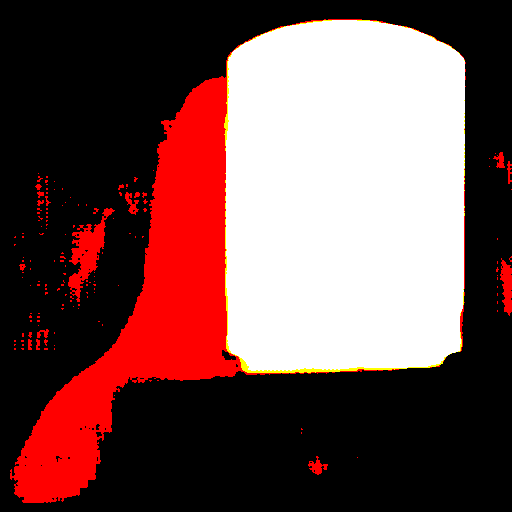

In [8]:
Image.fromarray(mask)

In [10]:
from diffusers import StableDiffusionInpaintPipeline, StableDiffusionPipeline
import albumentations as A

In [11]:
prompt_fr = "apple, books"
prompt_bg = "table"
negative_prompt = "longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, letters" 

In [12]:
# Define image transformation
transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.4, scale_limit=(-0.4, -0.4), rotate_limit=0, p=1, border_mode=1, interpolation=4,
                       shift_limit_y=[0.1, 0.25])
])

torch_dtype = torch.float32
if torch.cuda.is_available():
    torch_dtype = torch.float16


# model_id_inpainting = "runwayml/stable-diffusion-inpainting"
# model_id_t2i = "runwayml/stable-diffusion-v1-5"

model_id_inpainting = "stabilityai/stable-diffusion-2-inpainting"
model_id_t2i = "stabilityai/stable-diffusion-2-1"

In [13]:
pipeline_inpainting = StableDiffusionInpaintPipeline.from_pretrained(model_id_inpainting, torch_dtype=torch_dtype)
pipeline_t2i = StableDiffusionPipeline.from_pretrained(model_id_t2i, torch_dtype=torch_dtype)

pipeline_inpainting = pipeline_inpainting.to(device)
pipeline_t2i = pipeline_t2i.to(device)

vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [14]:
def find_contour(image):
    """
    Finds contours in the given image.

    Args:
        image (numpy.ndarray): The input image.

    Returns:
        tuple: A tuple containing the contours and the thresholded image.
    """
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply binary thresholding
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Find contours
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2]
    # Return the contours
    return contours, thresh

def get_centroid(contour):
    """
    Calculates the centroid of a contour.

    Args:
        contour (numpy.ndarray): The input contour.

    Returns:
        tuple: A tuple containing the centroid coordinates (x, y).
    """
    M = cv2.moments(contour)
    if M['m00'] != 0:
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
    else:
        cx = 0
        cy = 0
    return cx, cy

In [35]:

print("Executing predict_fn from inference.py ...")
result = {}
with torch.no_grad():
    image_bg = pipeline_t2i(prompt_bg, guidance_scale=10).images[0]

    # Apply image transformation and blend with the background
    transformed_image_mask = transform(image=np.array(img), mask=np.array(mask))
    image_np = np.array(image_bg)
    idx = np.where(transformed_image_mask["mask"] == 0)
    image_np[idx[0], idx[1], :] = transformed_image_mask["image"][idx[0], idx[1], :]
    transformed_image_mask["image"] = image_np

    # Find the contours and centroid of the mask
    contours, ret = find_contour(transformed_image_mask["mask"])
    cx, cy = get_centroid(contours[0])
    max_min_cy = (contours[0][:, 0, 1].max() - contours[0][:, 0, 1].min()) // 3

    # Create masks for the lower and upper portions of the object
    anchor_point = int(np.random.uniform(0, max_min_cy))
    anti_mask = np.copy(transformed_image_mask["mask"])
    anti_mask[(cy - anchor_point):, :] = 0
    anti_mask_lower = 255 - (transformed_image_mask["mask"] - anti_mask)

    anti_mask = np.copy(transformed_image_mask["mask"])
    anti_mask[:(cy - anchor_point), :] = 0
    anti_mask_upper = 255 - (transformed_image_mask["mask"] - anti_mask)
    anti_mask_upper = Image.fromarray(255 - anti_mask_upper).filter(ImageFilter.GaussianBlur(4))
    new_mask_ori = Image.fromarray(transformed_image_mask["mask"])
    new_mask = new_mask_ori.filter(ImageFilter.GaussianBlur(8))

    transformed_image_mask["mask"] = 255 - anti_mask_lower
    transformed_image_mask["mask"] = np.array(
        Image.fromarray(transformed_image_mask["mask"]).filter(ImageFilter.GaussianBlur(4)))

    image_fr = Image.fromarray(transformed_image_mask["image"])

    # Run the inpainting pipeline on the foreground image
    image_fr = pipeline_inpainting(
        prompt=prompt_fr,
        image=image_fr,
        mask_image=Image.fromarray(transformed_image_mask["mask"]),
        num_inference_steps=50,
        guidance_scale=8.5,
        negative_prompt=negative_prompt
    ).images[0]

    # Run the inpainting pipeline on the background image
    image_fr = pipeline_inpainting(
        prompt=prompt_bg,
        image=image_fr,
        mask_image=anti_mask_upper,
        num_inference_steps=50,
        guidance_scale=8.5,
        negative_prompt=negative_prompt
    ).images[0]

    result["image"] = image_fr
    result["background"] = image_bg
    result["mask"] = Image.fromarray(((1 - np.array(new_mask) / 255) * (1) * 255).astype(np.uint8))

    scale = (1 - np.array(new_mask_ori)/255)*(1 - np.array(new_mask_ori)/255)
    image_np = scale*transformed_image_mask["image"] + (1 - scale)*image_fr
    result["postprocess_image"] = Image.fromarray(image_np.astype(np.uint8))


    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()


Executing predict_fn from inference.py ...


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

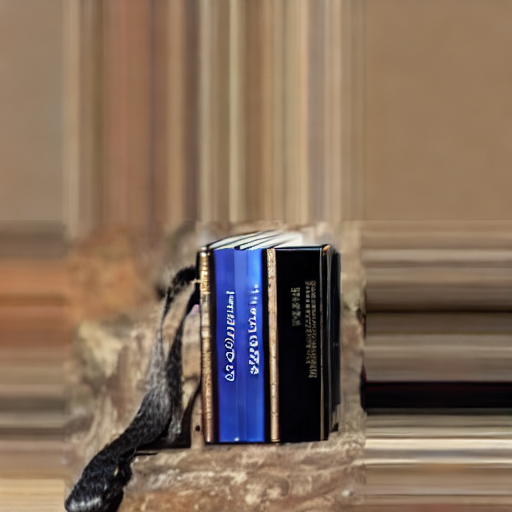

In [40]:
image_fr

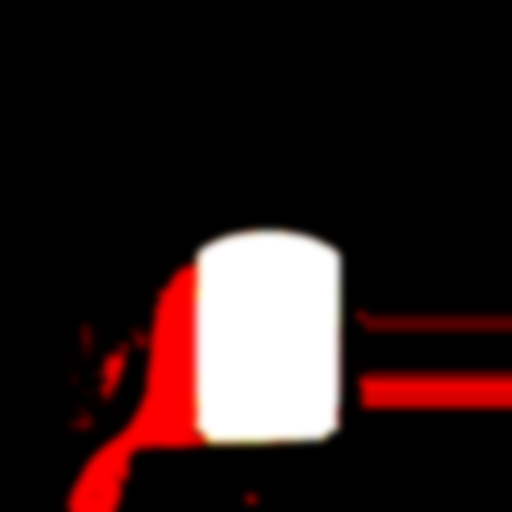

In [39]:
Image.fromarray(transformed_image_mask["mask"])

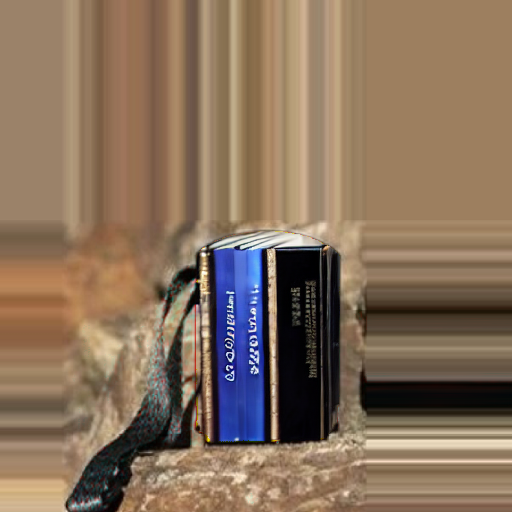

In [36]:
result["postprocess_image"]

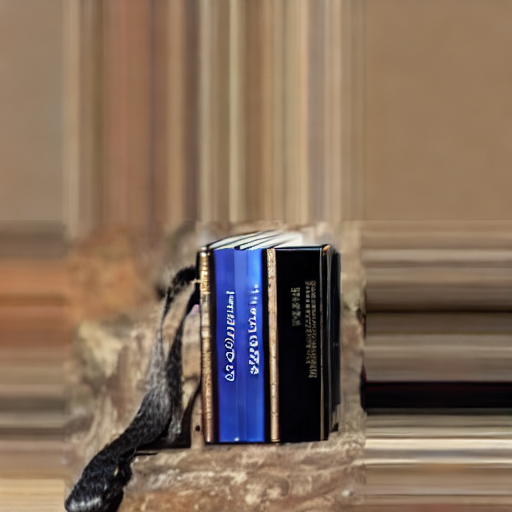

In [37]:
result['image']

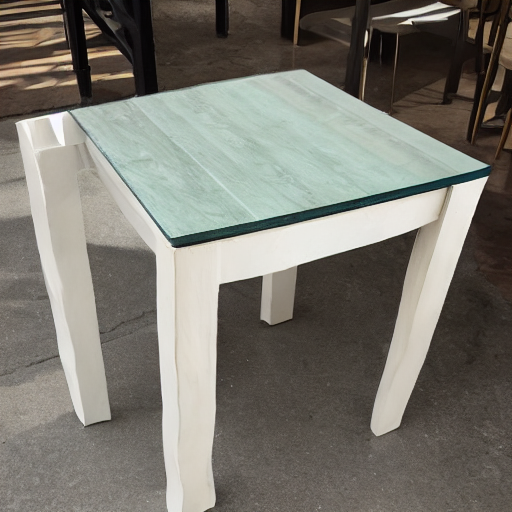

In [38]:
result['background']

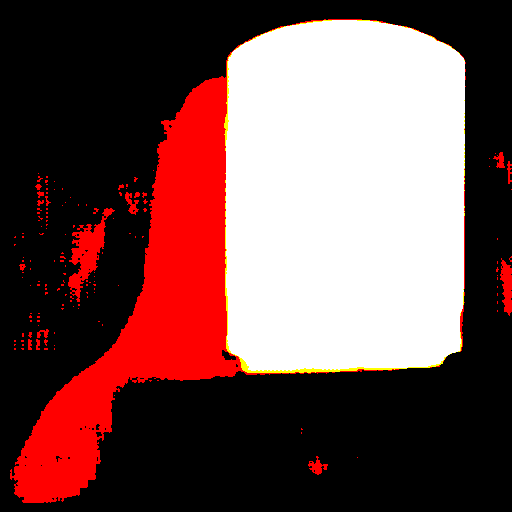

In [17]:
Image.fromarray(mask)